
Observações válidas (n) = 100000
                     count        mean         std     min       25%      50%  \
valor_cupom       100000.0  550.489585  259.410143  100.01  326.6275  550.265   
repasse_picmoney  100000.0   70.474739   90.823519    1.07   16.1800   32.815   

                     75%     max  
valor_cupom       774.91  999.96  
repasse_picmoney   80.16  497.32  

=== Resultados (IC 95%) ===

1) Repasse (repasse_picmoney):
   média = 70.4747 R$
   sd = 90.8235, SE = 0.2872, df = 99999
   IC95% (t) = (69.9118, 71.0377) R$
   IC95% (bootstrap percentil, 2000) = (69.9169, 71.0228) R$

2) Valor do cupom (valor_cupom):
   média = 550.4896 R$
   sd = 259.4101, SE = 0.8203, df = 99999
   IC95% (t) = (548.8818, 552.0974) R$

3) Proporção de transações com repasse > 0:
   k = 100000, n = 100000, p̂ = 1.0000
   IC95% (Wilson) = (1.0000, 1.0000)

4) Correlação (Pearson) entre valor_cupom e repasse_picmoney:
   r = 0.3690, p-value = 0.0000e+00
   IC95% (Fisher z) = (0.3636, 0.3743

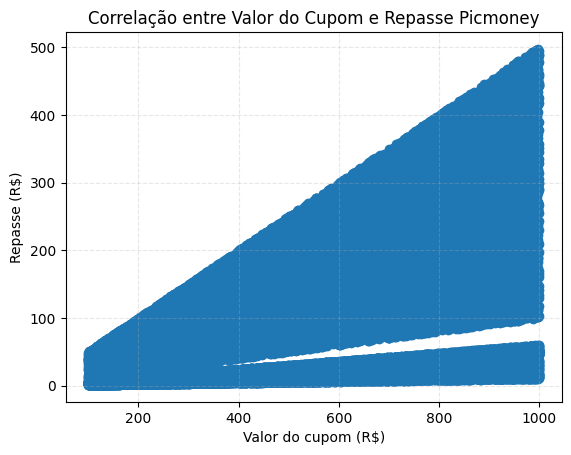

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint


csv_path = "PicMoney-Base_de_Transa__es_-_Cupons_Capturados-100000 linhas (1).csv"

# garantir numérico
df_disp['valor_cupom'] = pd.to_numeric(df_disp['valor_cupom'], errors='coerce')
df_disp['repasse_picmoney'] = pd.to_numeric(df_disp['repasse_picmoney'], errors='coerce')
df_trans = pd.read_csv(csv_path, sep=";", decimal=",")


# remover NA
df_disp = df_disp.dropna().reset_index(drop=True)

n = len(df_disp)
print(f"\nObservações válidas (n) = {n}")
print(df_disp[['valor_cupom', 'repasse_picmoney']].describe().T)


def mean_t_interval(x, alpha=0.05):
    x = np.array(x).astype(float)
    n = len(x)
    mean = x.mean()
    sd = x.std(ddof=1)
    se = sd / np.sqrt(n)
    df = n - 1
    t_crit = stats.t.ppf(1 - alpha/2, df)
    lo = mean - t_crit * se
    hi = mean + t_crit * se
    return mean, sd, se, (lo, hi), df

def pearson_ci(r, n, alpha=0.05):
    zr = np.arctanh(r)
    se_z = 1/np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)
    lo_z = zr - z_crit * se_z
    hi_z = zr + z_crit * se_z
    return r, (np.tanh(lo_z), np.tanh(hi_z))

def bootstrap_mean_ci(x, n_boot=2000, alpha=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    x = np.array(x).astype(float)
    n = len(x)
    boots = rng.choice(x, size=(n_boot, n), replace=True)
    means = boots.mean(axis=1)
    lo = np.percentile(means, 100 * (alpha/2))
    hi = np.percentile(means, 100 * (1 - alpha/2))
    return means.mean(), (lo, hi)


# Média do repasse
mean_rep, sd_rep, se_rep, ci_rep, df_rep = mean_t_interval(df_disp['repasse_picmoney'])
# Média do valor do cupom
mean_cup, sd_cup, se_cup, ci_cup, df_cup = mean_t_interval(df_disp['valor_cupom'])
# Proporção: repasse > 0
indicator = (df_disp['repasse_picmoney'] > 0).astype(int)
k = int(indicator.sum())
p_hat = k / n
prop_lo, prop_hi = proportion_confint(count=k, nobs=n, method='wilson')
# Correlação de Pearson e IC (Fisher z)
r_val, p_r = stats.pearsonr(df_disp['valor_cupom'], df_disp['repasse_picmoney'])
r_val, (r_lo, r_hi) = pearson_ci(r_val, n)

# Bootstrap para média do repasse (opcional)
bs_mean_rep, (bs_lo_rep, bs_hi_rep) = bootstrap_mean_ci(df_disp['repasse_picmoney'], n_boot=2000)

# Mostrar resultados formatados (pronto para relatório)
print("\n=== Resultados (IC 95%) ===\n")
print("1) Repasse (repasse_picmoney):")
print(f"   média = {mean_rep:.4f} R$")
print(f"   sd = {sd_rep:.4f}, SE = {se_rep:.4f}, df = {df_rep}")
print(f"   IC95% (t) = ({ci_rep[0]:.4f}, {ci_rep[1]:.4f}) R$")
print(f"   IC95% (bootstrap percentil, 2000) = ({bs_lo_rep:.4f}, {bs_hi_rep:.4f}) R$")

print("\n2) Valor do cupom (valor_cupom):")
print(f"   média = {mean_cup:.4f} R$")
print(f"   sd = {sd_cup:.4f}, SE = {se_cup:.4f}, df = {df_cup}")
print(f"   IC95% (t) = ({ci_cup[0]:.4f}, {ci_cup[1]:.4f}) R$")

print("\n3) Proporção de transações com repasse > 0:")
print(f"   k = {k}, n = {n}, p̂ = {p_hat:.4f}")
print(f"   IC95% (Wilson) = ({prop_lo:.4f}, {prop_hi:.4f})")

print("\n4) Correlação (Pearson) entre valor_cupom e repasse_picmoney:")
print(f"   r = {r_val:.4f}, p-value = {p_r:.4e}")
print(f"   IC95% (Fisher z) = ({r_lo:.4f}, {r_hi:.4f})")


summary = pd.DataFrame({
    'metric': ['mean_repasse', 'mean_valor_cupom', 'prop_repasse_gt0', 'pearson_r'],
    'estimate': [mean_rep, mean_cup, p_hat, r_val],
    'CI_lower': [ci_rep[0], ci_cup[0], prop_lo, r_lo],
    'CI_upper': [ci_rep[1], ci_cup[1], prop_hi, r_hi]
})
print("\nResumo (DataFrame):")
print(summary)


report_text = f"""
Construção e Interpretação de Intervalos de Confiança (IC 95%):

1) Média do repasse (repasse_picmoney)
   - Estimativa pontual (média): {mean_rep:.4f} R$
   - IC 95% (t-based): ({ci_rep[0]:.4f}, {ci_rep[1]:.4f}) R$
   Interpretação: com 95% de confiança, o verdadeiro valor médio do repasse encontra-se entre {ci_rep[0]:.4f} R$ e {ci_rep[1]:.4f} R$.

2) Média do valor do cupom (valor_cupom)
   - Estimativa pontual (média): {mean_cup:.4f} R$
   - IC 95% (t-based): ({ci_cup[0]:.4f}, {ci_cup[1]:.4f}) R$

3) Proporção de transações com repasse > 0
   - Estimativa pontual (p̂): {p_hat:.4f}
   - IC 95% (Wilson): ({prop_lo:.4f}, {prop_hi:.4f})

4) Correlação entre valor do cupom e repasse
   - r = {r_val:.4f}, IC95% (Fisher z): ({r_lo:.4f}, {r_hi:.4f})

"""
print(report_text)


plt.scatter(df_disp['valor_cupom'], df_disp['repasse_picmoney'])
plt.title('Correlação entre Valor do Cupom e Repasse Picmoney')
plt.xlabel('Valor do cupom (R$)')
plt.ylabel('Repasse (R$)')
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()